### In this notebook, I'll be trying to find the answers to the following questions:
1. Does price impact longevity (sunk cost bias)?
2. Does a game being multiplayer affect longevity?
3.

In [45]:
import numpy as np
import pandas as pd

In [46]:
df = pd.read_csv("joined.csv")
df.dtypes

month                     object
avg_players              float64
gain                     float64
gain_percent             float64
peak_players               int64
name                      object
app_id                     int64
release_date              object
price                    float64
avg_owners               float64
metacritic_score         float64
positive_reviews         float64
negative_reviews         float64
genres                    object
tags                      object
developers                object
days_since_launch        float64
months_since_launch      float64
all_time_peak              int64
launch_peak              float64
all_time_launch_ratio    float64
is_green_month              bool
gain_consistency         float64
dtype: object

Preprocessing tags from comma-sepereated string into list because we just imported it from a csv. 

In [47]:
df['tags'] = df['tags'].fillna('') # so it doesn't crash
df['tags_list'] = df['tags'].str.split(', ')

In [48]:
df['month'] = pd.to_datetime(df['month'])
df['release_date'] = pd.to_datetime(df['release_date'])

In [49]:
df.describe().round(2)

/home/taidd/personal-projects/steam-data/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,month,avg_players,gain,gain_percent,peak_players,app_id,release_date,price,avg_owners,metacritic_score,positive_reviews,negative_reviews,days_since_launch,months_since_launch,all_time_peak,launch_peak,all_time_launch_ratio,gain_consistency
count,351868,351868.00,351535.00,351868.00,351868.00,351868.00,351868,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00,351868.00
mean,2020-09-19 16:04:26.499937536,824.82,-9.82,4.09,1656.32,406850.60,2016-03-31 15:23:05.496834304,13.46,989612.00,28.63,15206.65,2378.25,1633.03,53.95,9277.47,3415.27,inf,0.44
min,2012-07-01 00:00:00,0.00,-231001.16,-1.00,0.00,730.00,2012-05-04 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,1.00,0.00
25%,2018-07-01 00:00:00,5.48,-4.49,-0.18,19.00,269950.00,2014-09-23 00:00:00,2.99,150000.00,0.00,614.00,131.00,737.00,24.00,342.00,68.00,1.61,0.41
50%,2020-11-01 00:00:00,20.43,-0.21,-0.03,60.00,372360.00,2016-03-14 00:00:00,9.99,350000.00,0.00,2017.00,356.00,1515.00,50.00,1029.00,239.00,3.22,0.44
75%,2023-03-01 00:00:00,102.41,2.11,0.14,272.00,527190.00,2017-08-21 00:00:00,19.99,750000.00,73.00,6643.00,1144.00,2406.00,80.00,3581.00,1041.00,8.64,0.47
max,2025-09-01 00:00:00,1584886.77,199431.80,450903.59,3236027.00,802200.00,2025-03-27 00:00:00,269.99,75000000.00,97.00,5764420.00,895978.00,4868.00,162.00,3236027.00,3236027.00,inf,0.73
std,NaN,14055.25,1636.50,861.48,25979.61,166437.02,NaN,13.41,3225734.56,36.86,131981.75,22950.43,1066.63,35.55,70564.91,53768.60,NaN,0.05


For the first question, "What do the lifespans of games in different genres look like?" we have to determine what lifespan is. The way I'm choosing to quantify lifespan is by calculating the "half-life." The problem with this is that some games increase since month 1, so I will be seperating games into "decay" and "growth" games. I'll do this by finding the ratio of peak_players all time and peak_players in month 1. 

In [50]:
df['all_time_launch_ratio'].describe()

/home/taidd/personal-projects/steam-data/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.518680e+05
mean              inf
std               NaN
min      1.000000e+00
25%      1.605536e+00
50%      3.216216e+00
75%      8.638889e+00
max               inf
Name: all_time_launch_ratio, dtype: float64

Where the all time month 1 ratio is 1, the first month was the most popular. These are decay games. I also am going to categorize the games into price buckets.

In [51]:
conditions = [
    df['price'] == 0,
    df['price'] < 20,
    df['price'] >= 60
]

choices = ['Free', 'Budget', 'AAA']

df['price_tier'] = np.select(conditions, choices, default='Standard')

I'm testing the sunk cost theory now. For non-positive review games, does price affect the half-life of the games? If there is no sunk cost, then for bad games, people would spend the same amount of time on the game regardless of how much money they spent on the game.

In [52]:
df['is_decayed'] = (
    (df['peak_players'] <= (df['launch_peak'] * 0.5)) & 
    (df['months_since_launch'] > 1)
) # decayed if its older than 1 month and the month's player peak is less than the peak at launch

In [53]:
decayed_rows = df[df['is_decayed'] == True]

half_life_series = decayed_rows.groupby('app_id')['months_since_launch'].min()

df = pd.merge(df, half_life_series.rename('half_life'), 
                    left_on='app_id', right_index=True, how='left')

In [54]:
print(df.groupby('app_id')['is_decayed'].nunique().describe())

count    3664.000000
mean        1.923035
std         0.266572
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: is_decayed, dtype: float64


This shows that most games have decayed. nunique of 1 means that it has not decayed and nunique of 2 means that it has decayed at some point.

In [55]:
df['proportion_positive'] = df['positive_reviews'] / (df['negative_reviews'] + df['positive_reviews'])
bad_games = df[df['proportion_positive'] < 0.5] # not many games exist where the reviews are mostly negative

In [56]:
summary_table = bad_games.groupby('price_tier')['half_life'].agg(
    Median_Life='median',
    Mean_Life='mean',
    Game_Count='count'
).round(2)

print(summary_table)

            Median_Life  Mean_Life  Game_Count
price_tier                                    
Budget              3.0       5.86        9194
Free                2.0       6.71        2222
Standard            2.0       3.56        1141


It seems like there is at least a difference between the free and budget tier games. Time to plot!

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

Text(0.5, 0, 'Price Tier')

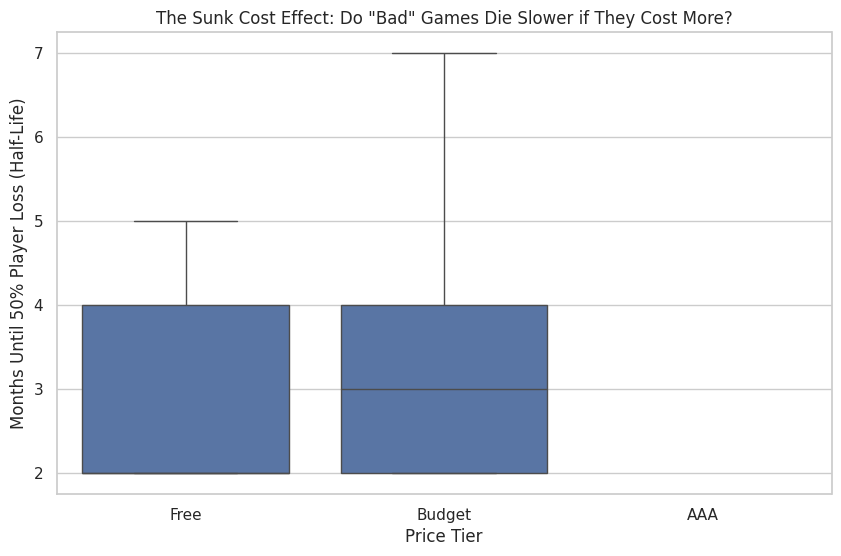

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_tier', y='half_life', data=bad_games, order=['Free', 'Budget', 'AAA'], showfliers=False)
plt.title('The Sunk Cost Effect: Do "Bad" Games Die Slower if They Cost More?')
plt.ylabel('Months Until 50% Player Loss (Half-Life)')
plt.xlabel('Price Tier')

No AAA games? This is probably due to AAA games having higher reviews, so there are no "bad" AAA games.

In [59]:
print(df.groupby('price_tier')['proportion_positive'].describe())

               count      mean       std       min       25%       50%  \
price_tier                                                               
AAA            455.0  0.890545  0.048232  0.803118  0.901294  0.901294   
Budget      232850.0  0.815061  0.137302  0.145969  0.755102  0.852594   
Free         57252.0  0.752954  0.135629  0.164948  0.659091  0.764610   
Standard     60008.0  0.815724  0.117581  0.337646  0.754599  0.838428   

                 75%       max  
price_tier                      
AAA         0.903846  0.952703  
Budget      0.915236  1.000000  
Free        0.861309  0.978682  
Standard    0.906104  0.986196  


This supports my hypothesis. The lowest review AAA game in the data set has 80% positive ratings. I'm going to redefine the boundaries, so we can see free vs budget vs standard

In [60]:
conditions = [
    df['price'] == 0,
    df['price'] < 15,    # "Budget" (Indies)
    df['price'] >= 15    # "Standard" (AA / Old AAA)
]
choices = ['Free', 'Budget', 'Standard']

df['price_tier'] = np.select(conditions, choices, default='Standard')

bad_games = df[df['proportion_positive'] < 0.60] # slightly laxing the barrier because the vast majority of games are highly rated.

In [61]:
summary = bad_games.groupby('price_tier')['half_life'].agg(
    Median_Life='median',
    Mean_Life='mean',
    Game_Count='count',
    std='std'
).reindex(['Free', 'Budget', 'Standard'])

print(summary)

            Median_Life  Mean_Life  Game_Count        std
price_tier                                               
Free                2.0   5.428725        8355   8.556046
Budget              3.0   6.522202       16327   9.036635
Standard            2.0   6.818134        5702  13.842756


/tmp/ipykernel_87557/5569567.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


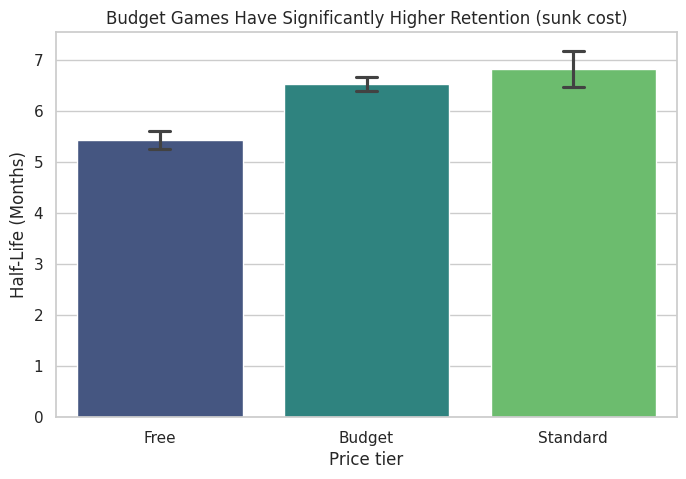

In [62]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=bad_games, 
    x='price_tier', 
    y='half_life',
    order=['Free', 'Budget', 'Standard'],
    errorbar=('ci', 95),  # This automatically calculates and draws the 95% interval
    capsize=0.1,
    palette='viridis'
)

plt.title('Budget Games Have Significantly Higher Retention (sunk cost)')
plt.ylabel('Half-Life (Months)')
plt.xlabel('Price tier')
plt.show()

We can see that budget games have statistically significantly longer half-lives than free and standard games. I hypothesized that as price tier increases, the half-life would increase as people spent more money and are more likely to play the game more due to sunk cost, but the standard priced games having a shorter half-life than budget games refutes my hypothesis. It is possible that for higher priced games, people are less patient with mediocrity. If a $40 game is mixed or bad, they may feel ripped off and quit or refund the game quickly. They may be less forgiving to the expensive game than the quirky $5 indie game.

Next, I will be looking at whether the multiplayer tag affects the longevity of the game.

In [63]:
df['is_multiplayer'] = df['tags_list'].apply(lambda x: 'Multiplayer' in x)

In [64]:
df['is_multiplayer'].mean() #proportion of games that are multiplayer

np.float64(0.4101424397785533)

In [65]:
df_growth = df[df['launch_peak'] > 10].copy()
df_growth['has_grown'] = df_growth['all_time_launch_ratio'] > 1.1
unique_games = df_growth.drop_duplicates(subset=['app_id']).copy() # so we don't count games multiple times
unique_games['launch_peak']

0         36057.0
157         548.0
315        2526.0
457          66.0
612        7067.0
           ...   
351637      112.0
351710      116.0
351744      380.0
351829     3504.0
351835       52.0
Name: launch_peak, Length: 3338, dtype: float64

Now we can see if multiplayer games grow bigger by looking at the median all time launch ratio, seeing by what multiplyer games players increase since launch and by seeing if the proportion of games that have grown since launch is higher for multiplayer.

In [66]:
comparison = unique_games.groupby('is_multiplayer').agg(
    Median_Growth=('all_time_launch_ratio', 'median'),
    Mean_Growth=('all_time_launch_ratio', 'mean'),
    Chance_to_Grow=('has_grown', 'mean'), # Returns the % of True values
    Count=('app_id', 'count'),
    
).round(3)

print(comparison)

print(print(unique_games.groupby('is_multiplayer')['all_time_launch_ratio'].quantile([0.25,0.5,0.75,0.90,0.95,0.97,0.99])))

                Median_Growth  Mean_Growth  Chance_to_Grow  Count
is_multiplayer                                                   
False                   3.357       25.097           0.868   1949
True                    2.623       21.123           0.847   1389
is_multiplayer      
False           0.25      1.670732
                0.50      3.357143
                0.75      8.000000
                0.90     25.172973
                0.95     51.966912
                0.97     87.388000
                0.99    245.434958
True            0.25      1.461823
                0.50      2.622560
                0.75      5.748031
                0.90     14.717670
                0.95     31.114982
                0.97     58.522062
                0.99    117.293799
Name: all_time_launch_ratio, dtype: float64
None


We can see that this is heavily right skewed on both ends. Meaning that there are a few games that have grown from their launch to a peak player number many factors larger than other games.

In [67]:
unique_games.sort_values(by='all_time_launch_ratio', ascending=False)[['name', 'all_time_peak', 'launch_peak','all_time_launch_ratio']].head(10)

,name,all_time_peak,launch_peak,all_time_launch_ratio
121650,Skillshot City,213183,15.0,14212.200000
158846,The Descendant,126070,13.0,9697.692308
150680,Kholat,275043,42.0,6548.642857
192782,DISTRAINT: Deluxe Edition,162795,73.0,2230.068493
327257,BROKE PROTOCOL,145618,70.0,2080.257143
94385,A Story About My Uncle,189049,136.0,1390.066176
190604,Incitement 3,15403,13.0,1184.846154
307749,Soundpad,39857,41.0,972.121951
261497,Serial Cleaner,13927,16.0,870.437500
68821,Grimm,30886,44.0,701.954545


I realize that I need another metric to show how games gain players. I looked at these games' steam charts time series data and they all peaked quickly and dropped back down immediately. The new metric will be the percentage of months the month gains players. This will be done in the data-cleaning stage, so it can be used in the dataframes above.

In [68]:
unique_games.groupby('is_multiplayer')['gain_consistency'].describe()

,count,mean,std,min,25%,50%,75%,max
is_multiplayer,,,,,,,,
False,1949.0,0.443454,0.049462,0.000000,0.416667,0.444444,0.473214,0.705882
True,1389.0,0.432068,0.053134,0.148148,0.404040,0.435897,0.464286,0.732394


Here we can see that the the values of the gain consistency are very similar, meaning that both multiplayer and singleplayer games have a similar proportion of months where the peak players increased from the previous month. My original hypothesis was incorrect as I expected multiplayer games to grow more, but it seems like there is no real difference between singleplayer and multiplayer games in terms of growth.

### I'm going to test if the real virality difference comes from Free-to-play multiplayer games

This is because if one person invites friends to play a certain game, it is more likely to grow more if there is less barrier to entry.

In [69]:
conditions = [ #bucket populations
    (unique_games['price'] == 0) & (unique_games['is_multiplayer'] == True),
    (unique_games['price'] > 0) & (unique_games['is_multiplayer'] == True),
    (unique_games['is_multiplayer'] == False) # Singleplayer (Price doesn't matter as much)
]
choices = ['Free Multiplayer', 'Paid Multiplayer', 'Singleplayer']

unique_games['segment'] = np.select(conditions, choices, default='Singleplayer')

unique_games['segment'].value_counts()

segment
Singleplayer        1949
Paid Multiplayer    1022
Free Multiplayer     367
Name: count, dtype: int64

In [70]:
print(unique_games.groupby('segment')['all_time_launch_ratio'].quantile([0.5, 0.9, 0.95, 0.99]))

segment               
Free Multiplayer  0.50      1.707046
                  0.90     10.228009
                  0.95     21.787379
                  0.99     60.629683
Paid Multiplayer  0.50      3.029132
                  0.90     16.334918
                  0.95     38.323430
                  0.99    140.147457
Singleplayer      0.50      3.357143
                  0.90     25.172973
                  0.95     51.966912
                  0.99    245.434958
Name: all_time_launch_ratio, dtype: float64


This appears to disprove my hypothesis. There are multiple reasons why this could be the case. 
1. The free games have massive launches, so it is difficult to get multiple times more players than the large initial launch. 
2. Paid games often have early access communities (smaller launch peak) but dedicated fans where there is a possibility to grow factors of 10x larger than the launch peak.
3. It could be that the paid barrier to entry does not affect virality of games.

I'm going to see the launch peaks of games and see if free games really do have much larger initial launch peaks.

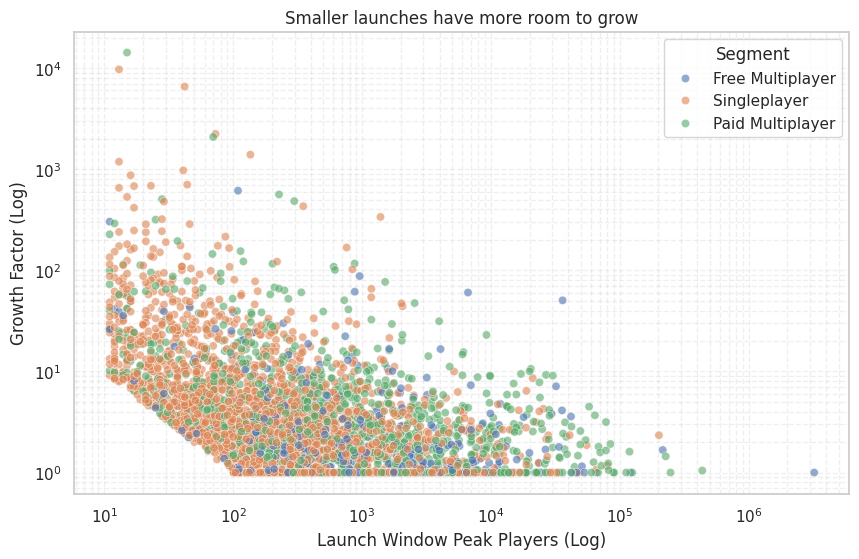

In [76]:
plt.figure(figsize=(10, 6))

# Plot Launch Peak vs Growth Factor
sns.scatterplot(
    data=unique_games,
    x='launch_peak',
    y='all_time_launch_ratio',
    hue='segment', # Color by Free/Paid/Single
    alpha=0.6,
    palette='deep'
)

# Both axes need log scales to see the pattern
plt.xscale('log')
plt.yscale('log')

plt.title('Smaller launches have more room to grow')
plt.xlabel('Launch Window Peak Players (Log)')
plt.ylabel('Growth Factor (Log)')
plt.legend(title='Segment')
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.show()

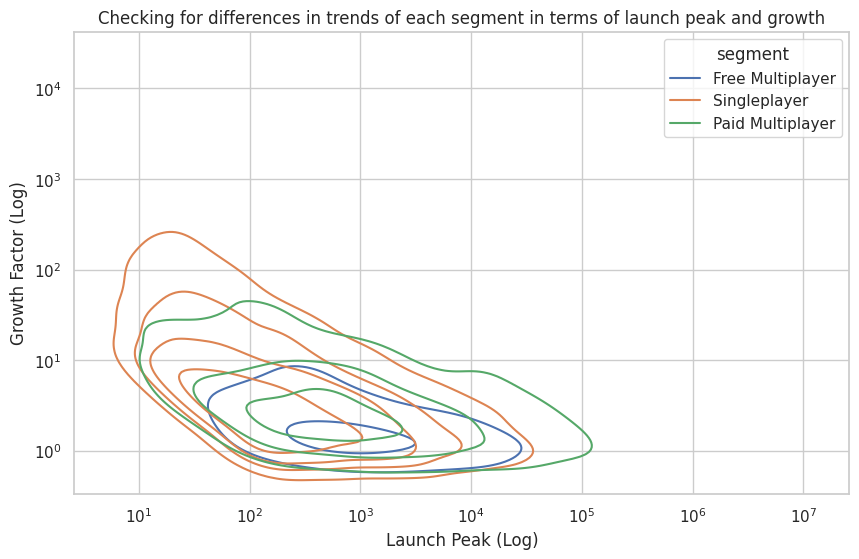

In [80]:
plt.figure(figsize=(10, 6))

sns.kdeplot( #This kde plot is kinda for fun
    data=unique_games,
    x='launch_peak',
    y='all_time_launch_ratio',
    hue='segment',
    fill=False,    
    levels=5,      
    thresh=0.1,    # Filter out the lowest density noise
    palette='deep',
    log_scale=True
)

plt.title('Checking for differences in trends of each segment in terms of launch peak and growth')
plt.xlabel('Launch Peak (Log)')
plt.ylabel('Growth Factor (Log)')
plt.show()

NOTE TO DO THE GRAPH OF MEAN GAME PLAYERS AND EVERY TAG PLAYERS IN ONE GRAPH